# Neural Network

In [1]:
import pandas as pd
import numpy as np
import joblib
import shap
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
"Read in clean-data"
df = pd.read_csv("clean_df.csv")

In [3]:
"Configure features and target"
# Define target column
target_col = "Price"

# Split features/target
x = df.drop(columns=[target_col])
y = df[target_col].astype(float)

In [4]:
"Configure features and target"
# Define target column
target_col = "Price"

# Split features/target
x = df.drop(columns=[target_col])
y = df[target_col].astype(float)

In [5]:
"Split data into training and test sets"
# Split: 80% train, 20% test
X_train, X_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=42
)

In [6]:
"Preprocess data"
print(f"Original X_train shape: {X_train.shape}")
print(f"Data types:\n{X_train.dtypes}")

# One-hot encoding for categorical variables
X_train_processed = pd.get_dummies(X_train, drop_first=True)
X_test_processed = pd.get_dummies(X_test, drop_first=True)

# Update variables for cross-validation
X_train = X_train_processed
X_test = X_test_processed

Original X_train shape: (39990, 7)
Data types:
Manufacturer            object
Model                   object
Engine size            float64
Fuel type               object
Year of manufacture      int64
Mileage                  int64
Car Age                  int64
dtype: object


In [7]:
"Cross-validation setup"
k_folds = 5 # Number of folds
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

# Define parameter grid to test 
param_combinations = [
    {'learning_rate': 0.001, 'batch_size': 32, 'epochs': 50, 'hidden_size': 64},
    {'learning_rate': 0.01, 'batch_size': 32, 'epochs': 50, 'hidden_size': 128},
    {'learning_rate': 0.001, 'batch_size': 64, 'epochs': 100, 'hidden_size': 64},
]

In [8]:
"Cross-validation function"
def cv_params(X_train, y_train, param_list, k_folds=5):
    """Cross-validation for neural network hyperparameters"""
    kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)
    best_score, best_params = float('inf'), None
    
    for i, params in enumerate(param_list):
        print(f"\nTesting {i+1}/{len(param_list)}: {params}")
        scores = []
        
        # Split and scale data
        for fold, (train_idx, val_idx) in enumerate(kf.split(X_train)):
            scaler = StandardScaler()
            X_tr = scaler.fit_transform(X_train.iloc[train_idx])
            X_val = scaler.transform(X_train.iloc[val_idx])
            y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
            
            # Build model
            model = Sequential([
                Dense(params['hidden_size'], activation='relu', input_dim=X_tr.shape[1]),
                Dense(params['hidden_size']//2, activation='relu'),
                Dense(params['hidden_size']//4, activation='relu'),
                Dense(1)
            ])
            model.compile(optimizer=Adam(learning_rate=params['learning_rate']), loss='mse')
            
            # Train
            model.fit(X_tr, y_tr, epochs=params['epochs'], batch_size=params['batch_size'],
                     validation_data=(X_val, y_val), verbose=0,
                     callbacks=[EarlyStopping(patience=10, restore_best_weights=True)])
            
            # Evaluate
            score = mean_squared_error(y_val, model.predict(X_val, verbose=0))
            scores.append(score)
            print(f"  Fold {fold+1}: {score:.4f}")
        
        # Track best
        avg_score = np.mean(scores)
        print(f"  Average: {avg_score:.4f} ± {np.std(scores):.4f}")
        
        if avg_score < best_score:
            best_score, best_params = avg_score, params
    
    print(f"Best: {best_params} (MSE: {best_score:.4f})")
    return best_params, best_score, []

In [9]:
"Run cross-validation to find best parameters"
best_params, best_score, all_results = cv_params(
    X_train, y_train, 
    param_combinations, 
    k_folds=5
)

print("\nAll parameter combinations tested:")
for i, result in enumerate(all_results):
    print(f"\n{i+1}. {result['params']}")
    print(f"   Average MSE: {result['avg_score']:.4f} ± {result['std_score']:.4f}")
    print(f"   Fold scores: {[f'{score:.4f}' for score in result['fold_scores']]}")

# Print best parameters
print(f"   BEST PARAMETERS FOUND:")
print(f"   Parameters: {best_params}")
print(f"   Best CV Score (MSE): {best_score:.4f}")
print(f"   Best CV Score (RMSE): {np.sqrt(best_score):.4f}")


Testing 1/3: {'learning_rate': 0.001, 'batch_size': 32, 'epochs': 50, 'hidden_size': 64}


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


  Fold 1: 47220.1895


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


  Fold 2: 38584.2072


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


  Fold 3: 59298.3199


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


  Fold 4: 42380.2418


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


  Fold 5: 42571.0243
  Average: 46010.7966 ± 7185.9321

Testing 2/3: {'learning_rate': 0.01, 'batch_size': 32, 'epochs': 50, 'hidden_size': 128}


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


  Fold 1: 59299.2218


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


  Fold 2: 70839.0429


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


  Fold 3: 117622.1235


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


  Fold 4: 107280.8618


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


  Fold 5: 97763.1954
  Average: 90560.8891 ± 22045.3359

Testing 3/3: {'learning_rate': 0.001, 'batch_size': 64, 'epochs': 100, 'hidden_size': 64}


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


  Fold 1: 39410.4241


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


  Fold 2: 32836.2251


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


  Fold 3: 48477.9497


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


  Fold 4: 26434.6728


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


  Fold 5: 33222.9185
  Average: 36076.4380 ± 7436.6410
Best: {'learning_rate': 0.001, 'batch_size': 64, 'epochs': 100, 'hidden_size': 64} (MSE: 36076.4380)

All parameter combinations tested:
   BEST PARAMETERS FOUND:
   Parameters: {'learning_rate': 0.001, 'batch_size': 64, 'epochs': 100, 'hidden_size': 64}
   Best CV Score (MSE): 36076.4380
   Best CV Score (RMSE): 189.9380


In [10]:
"Training final model with best parameters"

# Scale the full training data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create final model with best params
def create_final_model(params, input_dim):
    model = Sequential([
        Dense(params['hidden_size'], activation='relu', input_dim=input_dim),
        Dense(params['hidden_size']//2, activation='relu'),
        Dense(params['hidden_size']//4, activation='relu'),
        Dense(1) 
    ])
    
    model.compile(
        optimizer=Adam(learning_rate=params['learning_rate']),
        loss='mse',
        metrics=['mae']
    )
    return model

# Train final model
final_model = create_final_model(best_params, X_train_scaled.shape[1])

history = final_model.fit(
    X_train_scaled, y_train,
    epochs=best_params['epochs'],
    batch_size=best_params['batch_size'],
    validation_split=0.2, 
    verbose=1,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=15, restore_best_weights=True)]
)

print("Final model training complete!")

Epoch 1/100


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 484us/step - loss: 407613248.0000 - mae: 12674.4668 - val_loss: 55693684.0000 - val_mae: 3894.0591
Epoch 2/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 367us/step - loss: 48286196.0000 - mae: 3617.5891 - val_loss: 30834876.0000 - val_mae: 2880.1680
Epoch 3/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 368us/step - loss: 28191182.0000 - mae: 2789.9458 - val_loss: 23260810.0000 - val_mae: 2432.0391
Epoch 4/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 371us/step - loss: 24575202.0000 - mae: 2394.2183 - val_loss: 18801666.0000 - val_mae: 1719.6541
Epoch 5/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 367us/step - loss: 17661370.0000 - mae: 1773.2743 - val_loss: 14708700.0000 - val_mae: 1500.7421
Epoch 6/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 370us/step - loss: 15238431.0000 - mae: 1525.3582 - val_loss: 11352543.0000 - val_mae: 1307.5100
Epoch 7/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 370us/step - loss: 11325989.0000 - mae: 1242.5748 - val_loss: 8364515.5000 - val_mae: 1045.6808
Epoch 8/100
500/500 ━━━━

Epoch 1/100


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 501587616.0000 - mae: 14291.9775 - val_loss: 451525888.0000 - val_mae: 13196.0986
Epoch 2/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 849us/step - loss: 495669984.0000 - mae: 14146.7754 - val_loss: 449041408.0000 - val_mae: 13133.7422
Epoch 3/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 782us/step - loss: 486293568.0000 - mae: 13800.4902 - val_loss: 437706336.0000 - val_mae: 12870.7490
Epoch 4/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 755us/step - loss: 452964160.0000 - mae: 13116.6689 - val_loss: 404611168.0000 - val_mae: 12119.9180
Epoch 5/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 747us/step - loss: 406523744.0000 - mae: 12328.3838 - val_loss: 338057216.0000 - val_mae: 10576.8125
Epoch 6/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 767us/step - loss: 319514016.0000 - mae: 10574.1797 - val_loss: 242970384.0000 - val_mae: 8410.1133
Epoch 7/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 765us/step - loss: 222075280.0000 - mae: 8185.8018 - val_loss: 147170848.0000 - val_mae: 6325.8809
Epoch 8/100
50/5

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 794us/step - loss: 475906368.0000 - mae: 14043.0557 - val_loss: 443942016.0000 - val_mae: 13499.1035
Epoch 2/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 484us/step - loss: 435133088.0000 - mae: 13063.3789 - val_loss: 287654912.0000 - val_mae: 9760.9043
Epoch 3/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 472us/step - loss: 212030224.0000 - mae: 7757.6187 - val_loss: 66983204.0000 - val_mae: 4331.2139
Epoch 4/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 469us/step - loss: 58258752.0000 - mae: 4123.5693 - val_loss: 45945620.0000 - val_mae: 3673.3311
Epoch 5/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 467us/step - loss: 44627024.0000 - mae: 3563.3923 - val_loss: 37103296.0000 - val_mae: 3164.0159
Epoch 6/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 469us/step - loss: 37270516.0000 - mae: 3136.3704 - val_loss: 31848796.0000 - val_mae: 2933.7437
Epoch 7/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 467us/step - loss: 30998620.0000 - mae: 2860.8369 - val_loss: 28704104.0000 - val_mae: 2839.7263
Epoch 8/100
140/1

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 661us/step - loss: 473119872.0000 - mae: 14077.1250 - val_loss: 371771104.0000 - val_mae: 12124.3613
Epoch 2/100
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 432us/step - loss: 298596672.0000 - mae: 9914.5625 - val_loss: 54848412.0000 - val_mae: 3963.7322
Epoch 3/100
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 424us/step - loss: 58486064.0000 - mae: 3921.3657 - val_loss: 37913560.0000 - val_mae: 3245.2676
Epoch 4/100
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 421us/step - loss: 39581288.0000 - mae: 3215.6680 - val_loss: 30872896.0000 - val_mae: 3009.6611
Epoch 5/100
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 424us/step - loss: 32351148.0000 - mae: 2932.3438 - val_loss: 26346066.0000 - val_mae: 2699.6504
Epoch 6/100
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 423us/step - loss: 28522114.0000 - mae: 2596.3970 - val_loss: 22861128.0000 - val_mae: 2315.4009
Epoch 7/100
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 424us/step - loss: 24621982.0000 - mae: 2297.4778 - val_loss: 20492922.0000 - val_mae: 2126.6602
Epoch 8/100
230/230 

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 635us/step - loss: 456679392.0000 - mae: 13685.8809 - val_loss: 176852352.0000 - val_mae: 6322.4819
Epoch 2/100
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 415us/step - loss: 88746640.0000 - mae: 4721.1782 - val_loss: 51248180.0000 - val_mae: 3425.0991
Epoch 3/100
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 418us/step - loss: 39866700.0000 - mae: 3133.8103 - val_loss: 37622524.0000 - val_mae: 2892.0630
Epoch 4/100
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 408us/step - loss: 26928772.0000 - mae: 2720.5571 - val_loss: 31370438.0000 - val_mae: 2395.2329
Epoch 5/100
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 411us/step - loss: 21850046.0000 - mae: 2201.1541 - val_loss: 26807548.0000 - val_mae: 2157.4553
Epoch 6/100
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 414us/step - loss: 22708896.0000 - mae: 2057.3486 - val_loss: 23726762.0000 - val_mae: 1858.3485
Epoch 7/100
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 418us/step - loss: 17007988.0000 - mae: 1705.4991 - val_loss: 21105720.0000 - val_mae: 1778.6112
Epoch 8/100
320/320 ━━

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


410/410 ━━━━━━━━━━━━━━━━━━━━ 0s 511us/step - loss: 445871456.0000 - mae: 13311.9219 - val_loss: 80467104.0000 - val_mae: 4605.5728
Epoch 2/100
410/410 ━━━━━━━━━━━━━━━━━━━━ 0s 378us/step - loss: 61462964.0000 - mae: 4001.3313 - val_loss: 34121888.0000 - val_mae: 3046.9912
Epoch 3/100
410/410 ━━━━━━━━━━━━━━━━━━━━ 0s 374us/step - loss: 35796556.0000 - mae: 3038.1123 - val_loss: 24955304.0000 - val_mae: 2750.9355
Epoch 4/100
410/410 ━━━━━━━━━━━━━━━━━━━━ 0s 378us/step - loss: 25841278.0000 - mae: 2626.6455 - val_loss: 20562624.0000 - val_mae: 2276.8474
Epoch 5/100
410/410 ━━━━━━━━━━━━━━━━━━━━ 0s 381us/step - loss: 21543756.0000 - mae: 2278.3425 - val_loss: 17685808.0000 - val_mae: 1894.9602
Epoch 6/100
410/410 ━━━━━━━━━━━━━━━━━━━━ 0s 378us/step - loss: 20858210.0000 - mae: 1987.7758 - val_loss: 15007948.0000 - val_mae: 1705.3076
Epoch 7/100
410/410 ━━━━━━━━━━━━━━━━━━━━ 0s 376us/step - loss: 17829406.0000 - mae: 1717.8381 - val_loss: 12730264.0000 - val_mae: 1530.4362
Epoch 8/100
410/410 ━━━

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 780us/step - loss: 402221664.0000 - mae: 12419.7979 - val_loss: 51526860.0000 - val_mae: 3944.9492
Epoch 2/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 379us/step - loss: 44332360.0000 - mae: 3437.4583 - val_loss: 29074150.0000 - val_mae: 2882.1018
Epoch 3/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 374us/step - loss: 25736006.0000 - mae: 2705.3999 - val_loss: 22779626.0000 - val_mae: 2443.6768
Epoch 4/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 379us/step - loss: 22103136.0000 - mae: 2275.0425 - val_loss: 18325856.0000 - val_mae: 1879.3064
Epoch 5/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 377us/step - loss: 16688916.0000 - mae: 1744.7205 - val_loss: 14761961.0000 - val_mae: 1490.9930
Epoch 6/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 374us/step - loss: 14008797.0000 - mae: 1436.9714 - val_loss: 11656029.0000 - val_mae: 1308.5106
Epoch 7/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 377us/step - loss: 10507740.0000 - mae: 1161.8538 - val_loss: 8267644.5000 - val_mae: 980.8654
Epoch 8/100
500/500 ━━━━━

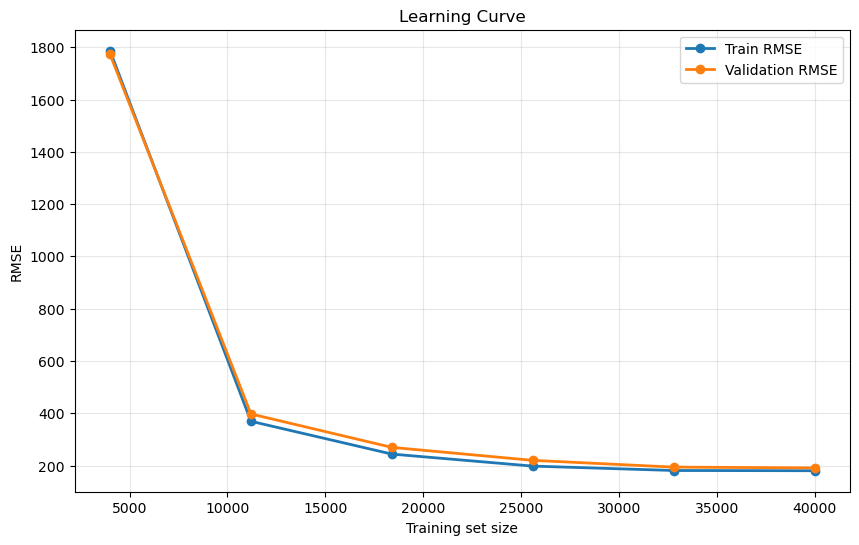

In [ ]:
"learning Curve"
train_sizes = np.linspace(0.1, 1.0, 6)
train_scores = []
val_scores = []

for size in train_sizes:
    n_samples = int(size * len(X_train_scaled))
    idx = np.random.choice(len(X_train_scaled), n_samples, replace=False)
    X_sample, y_sample = X_train_scaled[idx], y_train.iloc[idx]
    
    model = create_final_model(best_params, X_train_scaled.shape[1])
    model.fit(
        X_sample, y_sample,
        epochs=best_params['epochs'],
        batch_size=best_params['batch_size'],
        validation_split=0.2,
        verbose=1, 
        callbacks=[tf.keras.callbacks.EarlyStopping(patience=15, restore_best_weights=True)]
    )
    
    train_scores.append(np.sqrt(mean_squared_error(y_sample, model.predict(X_sample, verbose=0))))
    val_scores.append(np.sqrt(mean_squared_error(y_test, model.predict(X_test_scaled, verbose=0))))
    
    print(f"Size: {n_samples}/{len(X_train_scaled)} - Train: {train_scores[-1]:.4f}, Val: {val_scores[-1]:.4f}")

# Plot
train_sizes_actual = (train_sizes * len(X_train_scaled)).astype(int)
plt.figure(figsize=(10, 6))
plt.plot(train_sizes_actual, train_scores, "o-", label="Train RMSE", linewidth=2)
plt.plot(train_sizes_actual, val_scores, "o-", label="Validation RMSE", linewidth=2)
plt.xlabel("Training set size")
plt.ylabel("RMSE")
plt.legend()
plt.title("Learning Curve")
plt.grid(True, alpha=0.3)
plt.show()

In [12]:
print(X_train.shape[1])     # feature count p
final_model.summary()       # layer sizes & parameter counts


24


Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_60 (Dense)                │ (None, 64)             │         1,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_61 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_62 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_63 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,677 (49.52 KB)

 Trainable params: 4,225 (16.50 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 8,452 (33.02 KB)

In [13]:
"Newtwork summary and size"
final_model.summary()

Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_60 (Dense)                │ (None, 64)             │         1,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_61 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_62 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_63 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,677 (49.52 KB)

 Trainable params: 4,225 (16.50 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 8,452 (33.02 KB)

   Final test results:
   Mean Squared Error (MSE): 36271.9145
   Root Mean Squared Error (RMSE): 190.4519
   Mean Absolute Error (MAE): 117.4430
   R² Score: 0.9999
   Comparison:
   Cross-Validation RMSE: 189.9380
   Final Test RMSE: 190.4519
   Difference: 0.5139


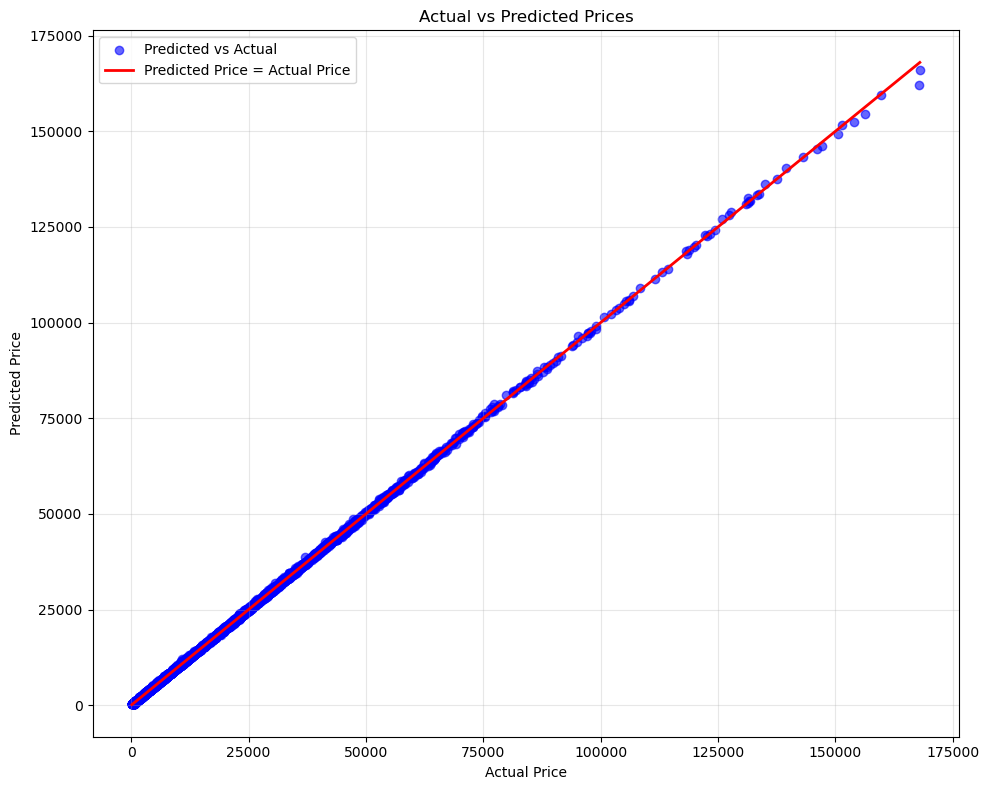

In [14]:
"Evaluate final model on test set"

# Make predictions on test set
test_predictions = final_model.predict(X_test_scaled, verbose=0)

# Calculate metrics
mse = mean_squared_error(y_test, test_predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, test_predictions)
r2 = r2_score(y_test, test_predictions)

# Print results
print(f"   Final test results:")
print(f"   Mean Squared Error (MSE): {mse:.4f}")
print(f"   Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"   Mean Absolute Error (MAE): {mae:.4f}")
print(f"   R² Score: {r2:.4f}")

print(f"   Comparison:")
print(f"   Cross-Validation RMSE: {np.sqrt(best_score):.4f}")
print(f"   Final Test RMSE: {rmse:.4f}")
print(f"   Difference: {abs(rmse - np.sqrt(best_score)):.4f}")

# Plot (predictions vs actual)
plt.figure(figsize=(10, 8))
plt.scatter(y_test, test_predictions, alpha=0.6, color='blue', label='Predicted vs Actual')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r-', lw=2, label='Predicted Price = Actual Price')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Actual vs Predicted Prices')
plt.grid(True, alpha=0.3)
plt.legend(loc='best', frameon=True)
plt.tight_layout()
plt.show()

In [15]:
"Save model"

#Metadata
model_info = {
    'best_params': best_params,
    'best_score': best_score,
    'feature_names': list(X_train.columns),
    'model_type': 'neural_network'
}

joblib.dump({
    'model': final_model,
    'scaler': scaler,
    'feature_names': list(X_train.columns),
    'metadata': model_info
}, 'NN_model.joblib')

# Load
loaded = joblib.load('NN_model.joblib')
model = loaded['model']
scaler = loaded['scaler']

In [16]:
"Function to predict on new data"
def predict_price(new_data):    
    new_data_scaled = scaler.transform(new_data)
    prediction = model.predict(new_data_scaled)
    return prediction[0][0]

In [17]:
"Example"
new_car_data = pd.DataFrame({
    'Make': ['Toyota'],
    'Model': ['Camry'],
    'Year': [2023],
    'Mileage': [25000],
    'Engine_Size': [2.5],
})

In [18]:
"Test prediction on samples from test set"
sample_new_data = X_test.iloc[:10].copy()  # Test samples
actual_prices = y_test.iloc[:10].copy()    # Actual prices (for comparison)

for i in range(len(sample_new_data)):
    sample_scaled = scaler.transform([sample_new_data.iloc[i]])

    # Make prediction
    predicted_price = model.predict(sample_scaled, verbose=0)[0][0]
    actual_price = actual_prices.iloc[i]
    error = abs(predicted_price - actual_price)
    percentage_error = (error / actual_price) * 100
    
    print(f"Sample {i+1}:")
    print(f"  Predicted Price: £{predicted_price:,.4f}")
    print(f"  Actual Price:    £{actual_price:,.4f}")
    print(f"  Error:           £{error:,.4f}")
    print(f"  Error %:         {percentage_error:.2f}%\n")

Sample 1:
  Predicted Price: £28,720.4238
  Actual Price:    £28,636.0000
  Error:           £84.4238
  Error %:         0.29%



/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have v

Sample 2:
  Predicted Price: £59,901.6758
  Actual Price:    £59,783.0000
  Error:           £118.6758
  Error %:         0.20%

Sample 3:
  Predicted Price: £14,798.7559
  Actual Price:    £14,865.0000
  Error:           £66.2441
  Error %:         0.45%

Sample 4:
  Predicted Price: £2,335.2173
  Actual Price:    £2,219.0000
  Error:           £116.2173
  Error %:         5.24%

Sample 5:
  Predicted Price: £1,059.4683
  Actual Price:    £1,001.0000
  Error:           £58.4683
  Error %:         5.84%

Sample 6:
  Predicted Price: £1,476.4078
  Actual Price:    £1,415.0000
  Error:           £61.4078
  Error %:         4.34%

Sample 7:
  Predicted Price: £105,662.0625
  Actual Price:    £106,073.0000
  Error:           £410.9375
  Error %:         0.39%

Sample 8:
  Predicted Price: £1,985.2573
  Actual Price:    £2,023.0000
  Error:           £37.7427
  Error %:         1.87%

Sample 9:
  Predicted Price: £15,649.2559
  Actual Price:    £15,492.0000
  Error:           £157.2559
  Er

  Processed 1/24 features...
  Processed 11/24 features...
  Processed 21/24 features...


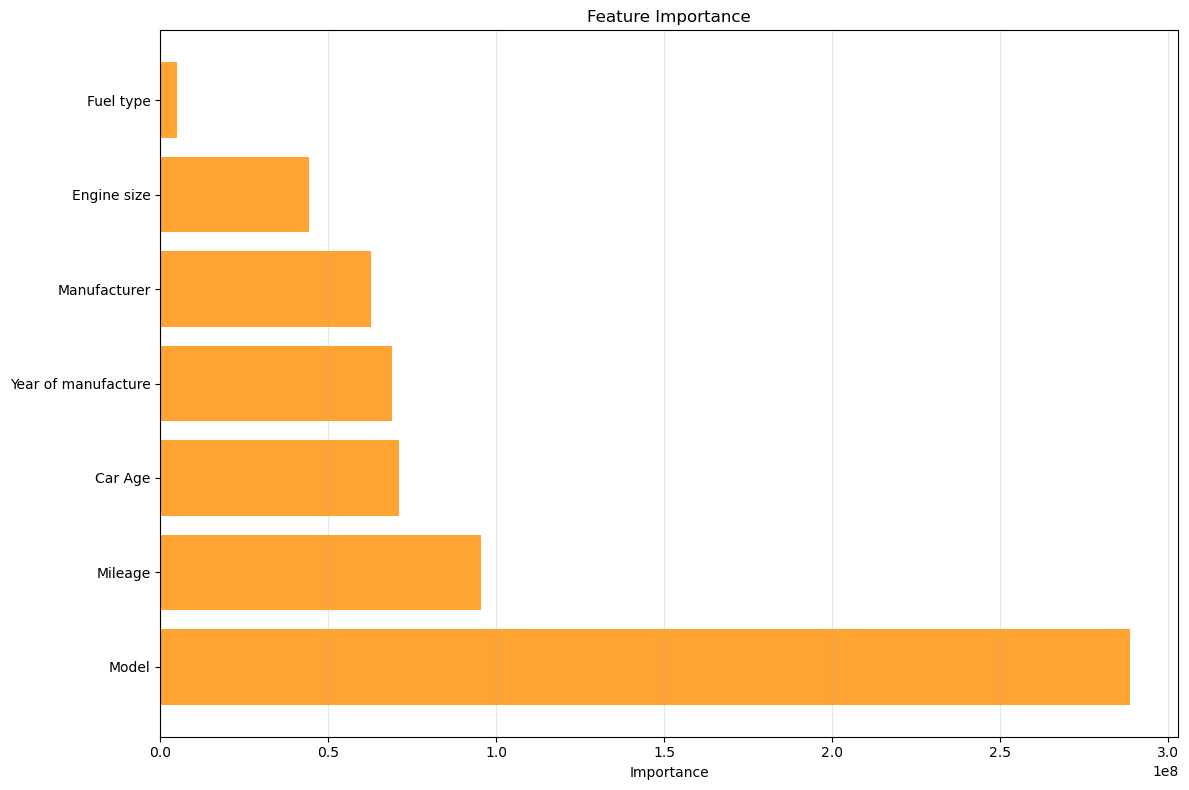

In [19]:
"Feature importance by permutation"
baseline_predictions = final_model.predict(X_test_scaled, verbose=0).flatten()
baseline_mse = mean_squared_error(y_test, baseline_predictions)

# Calculate importance for each feature
feature_importance_scores = []

for i, feature_name in enumerate(X_train.columns):
    X_test_permuted = X_test_scaled.copy()
    np.random.seed(42)
    X_test_permuted[:, i] = np.random.permutation(X_test_permuted[:, i])
    permuted_predictions = final_model.predict(X_test_permuted, verbose=0).flatten()
    permuted_mse = mean_squared_error(y_test, permuted_predictions)
    
    # Calculate importance 
    importance = permuted_mse - baseline_mse
    feature_importance_scores.append(importance)
    
    if i % 10 == 0: 
        print(f"  Processed {i+1}/{len(X_train.columns)} features...")

feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importance_scores
})

def group_feature_importance(df):
    grouped_importance = {}
    
    for _, row in df.iterrows():
        feature_name = row['Feature']
        importance = row['Importance']
        
        if feature_name.startswith('Manufacturer_'):
            category = 'Manufacturer'
        elif feature_name.startswith('Model_'):
            category = 'Model'
        elif feature_name.startswith('Fuel type_'):
            category = 'Fuel type'
        else:
            category = feature_name
        if category in grouped_importance:
            grouped_importance[category] += importance
        else:
            grouped_importance[category] = importance
    
    return grouped_importance

# Group features
grouped_scores = group_feature_importance(feature_importance_df)

# Sort
sort_descending = True 

grouped_df = pd.DataFrame(list(grouped_scores.items()), 
                         columns=['Feature', 'Importance']).sort_values('Importance', ascending=True)

plt.figure(figsize=(12, 8))
top_features = grouped_df.head(10) 

plt.barh(range(len(top_features)), top_features['Importance'], 
         color='#FF8C00', alpha=0.8)  # Orange color

# Labels
plt.yticks(range(len(top_features)), top_features['Feature'])
plt.xlabel('Importance')

plt.title(f'Feature Importance')

if sort_descending:
    plt.gca().invert_yaxis()

plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

In [20]:
"SHAP analysis"
n_background = 50  # Background samples
n_explain = 10     # Samples to explain

# Create wrapper function
def model_predict_shap(X):
    return final_model.predict(X, verbose=0).flatten()

# KernelExplainer
explainer = shap.KernelExplainer(model_predict_shap, X_train_scaled[:n_background])
shap_values = explainer.shap_values(X_test_scaled[:n_explain])

# Calculate feature importance
feature_importance = np.mean(np.abs(shap_values), axis=0)

# Create mapping of features to parent categories
def get_parent_feature(feature_name):
    if feature_name.startswith('Manufacturer_'):
        return 'Manufacturer'
    elif feature_name.startswith('Model_'):
        return 'Model'
    elif feature_name.startswith('Fuel type_'):
        return 'Fuel type'
    else:
        return feature_name

# Group SHAP values by parent feature and calculate mean
grouped_shap = {}
feature_counts = {}

for i, feature_name in enumerate(X_train.columns):
    parent_feature = get_parent_feature(feature_name)
    if parent_feature in grouped_shap:
        grouped_shap[parent_feature] += feature_importance[i]
        feature_counts[parent_feature] += 1
    else:
        grouped_shap[parent_feature] = feature_importance[i]
        feature_counts[parent_feature] = 1

# Calculate mean
for feature in grouped_shap:
    grouped_shap[feature] /= feature_counts[feature]

# Create DataFrame with grouped results
shap_df = pd.DataFrame({
    'Feature': list(grouped_shap.keys()),
    'SHAP_Importance': list(grouped_shap.values())
}).sort_values('SHAP_Importance', ascending=False)

  0%|          | 0/10 [00:00<?, ?it/s]

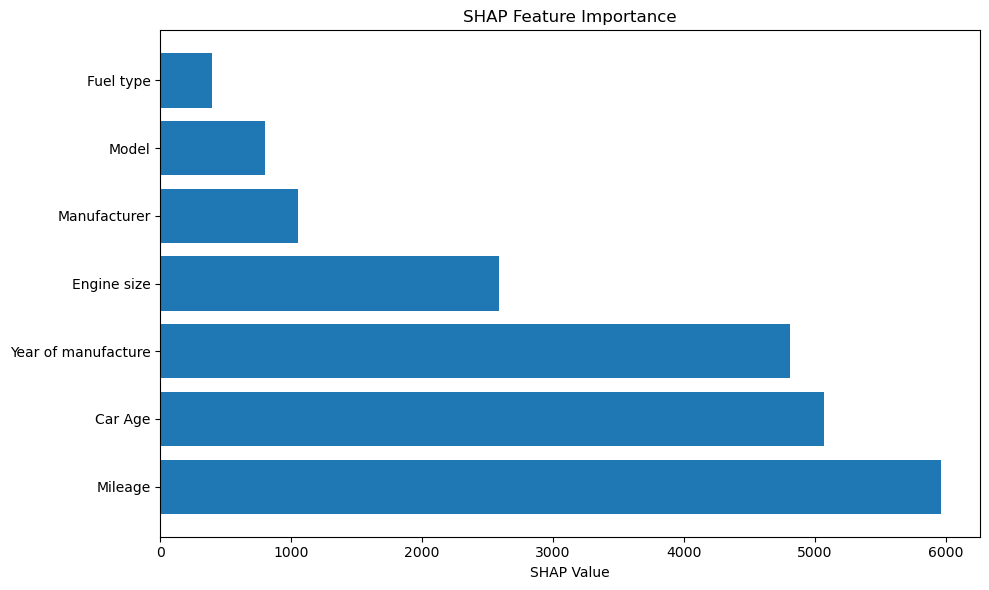

In [21]:
"Plot SHAP Feature Importance"
# Sort by importance
shap_df_sorted = shap_df.sort_values('SHAP_Importance', ascending=False)

# Create horizontal bar plot
plt.figure(figsize=(10, 6))
plt.barh(shap_df_sorted['Feature'], shap_df_sorted['SHAP_Importance'], color='#1f77b4')

plt.xlabel('SHAP Value')
plt.title('SHAP Feature Importance')
plt.tight_layout()
plt.show()